# Synthetic Population Generation

Generate sythetic schedules and attributes.

In [1]:
from pathlib import Path

import pandas as pd

from caveat.data.synth import ActivityGen
from caveat.data.utils import generate_population_conditional, trace_to_pam
from caveat.evaluate.describe.times import (
    joint_time_distributions_plot,
    times_distributions_plot,
)
from caveat.evaluate.describe.transitions import sequence_prob_plot

In [2]:
write_path = Path("tmp")
n = 1000

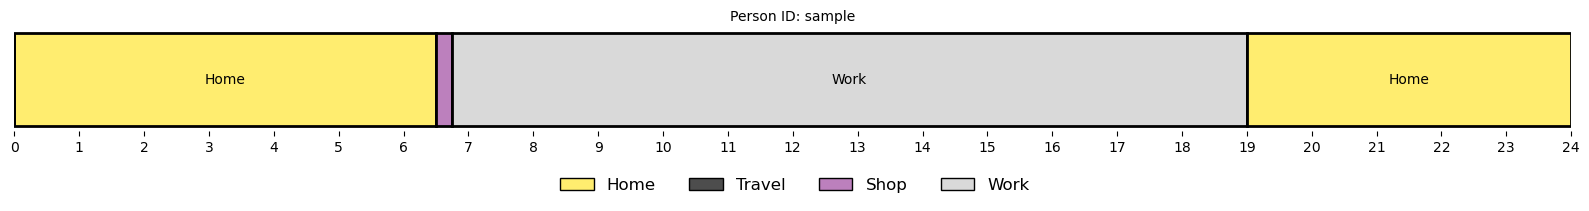

In [3]:
# FT worker generator
ftw = ActivityGen()
config = ftw.transition_config.copy()
for _, kv in config.items():
    for k, v in kv.items():
        if k in ["work"]:
            for i, (a, b) in enumerate(v):
                v[i] = (a, b * 10)
        if k in ["education", "shop", "leisure"]:
            for i, (a, b) in enumerate(v):
                v[i] = (a, b / 10)
ftw.build(config)

trace = ftw.run()
plan = trace_to_pam(trace, ftw.map)
plan.plot()

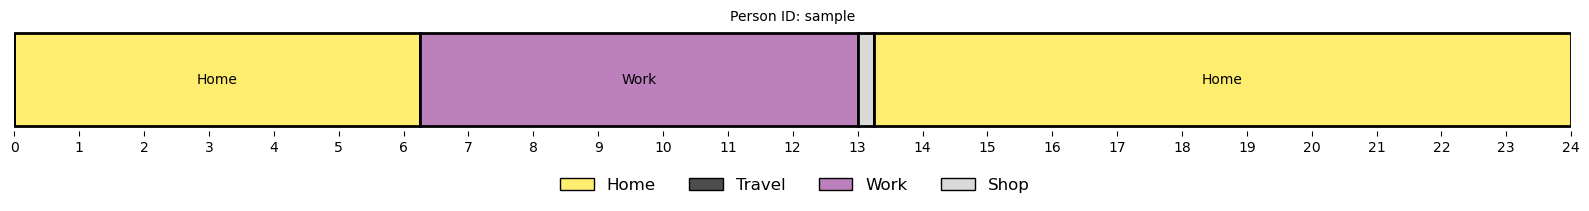

In [4]:
# PT worker generator
ptw = ActivityGen()
config = ptw.transition_config.copy()
for o, kv in config.items():
    for k, v in kv.items():
        if not o == "work":
            continue
        if k == "work":
            for i, (a, b) in enumerate(v):
                v[i] = (a, b / 100)
        if k in ["shop", "leisure"]:
            for i, (a, b) in enumerate(v):
                v[i] = (a, b * 100)
ptw.build(config)

trace = ptw.run()
plan = trace_to_pam(trace, ptw.map)
plan.plot()

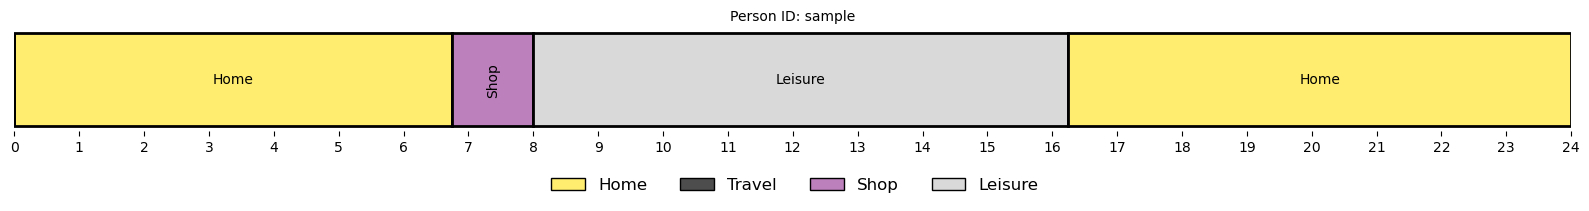

In [5]:
# Leisure generator
neet = ActivityGen()
config = neet.transition_config.copy()
for _, kv in config.items():
    for k, v in kv.items():
        if k in ["work", "education"]:
            for i, (a, b) in enumerate(v):
                v[i] = (a, 0)
        if k in ["shop", "leisure"]:
            for i, (a, b) in enumerate(v):
                v[i] = (a, b * 10)

neet.build(config)

trace = neet.run()
plan = trace_to_pam(trace, neet.map)
plan.plot()

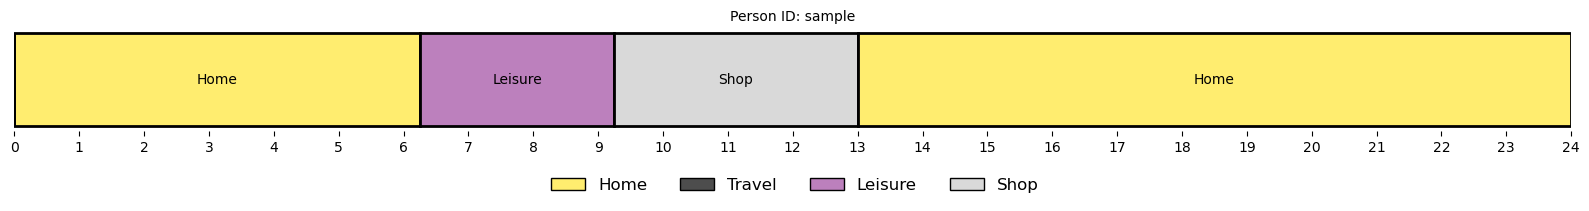

In [6]:
# FTE generator
fte = ActivityGen()
config = fte.transition_config.copy()
for _, kv in config.items():
    for k, v in kv.items():
        if k == "work":
            for i, (a, b) in enumerate(v):
                v[i] = (a, 0)
        if k == "education":
            for i, (a, b) in enumerate(v):
                v[i] = (a, b * 100)

fte.build(config)

trace = fte.run()
plan = trace_to_pam(trace, fte.map)
plan.plot()

In [7]:
population = generate_population_conditional(gens=(ftw, ptw, neet, fte), size=n)
population.act = population.act.map(ftw.map)
population = population[
    ["pid", "act", "start", "end", "duration", "gender", "age", "employment"]
]
population

pid      act  start   end  duration gender  age employment
0       0     home      0   375       375      F   24        FTW
1       0     work    375  1170       795      F   24        FTW
2       0     home   1170  1440       270      F   24        FTW
3       1     home      0   390       390      M   85       NEET
4       1     shop    390   450        60      M   85       NEET
...   ...      ...    ...   ...       ...    ...  ...        ...
4305  999     home      0   390       390      F   83       NEET
4306  999     shop    390   450        60      F   83       NEET
4307  999     home    450   630       180      F   83       NEET
4308  999  leisure    630   990       360      F   83       NEET
4309  999     home    990  1440       450      F   83       NEET

[4310 rows x 8 columns]

In [8]:
# population.to_csv(write_path / "combined.csv", index=False)
population[["pid", "act", "start", "end", "duration"]].to_csv(
    write_path / "synthetic_schedules.csv", index=False
)
population[["pid", "gender", "age", "employment"]].drop_duplicates().to_csv(
    write_path / "synthetic_attributes.csv", index=False
)

<Axes: xlabel='age', ylabel='duration'>

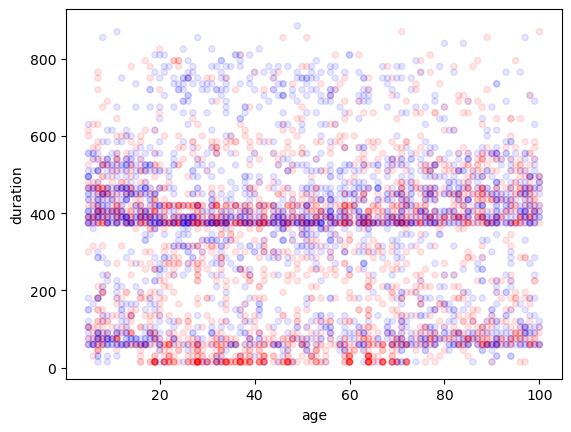

In [9]:
cs = population.gender.map({"M": "blue", "F": "red"})
population.plot(kind="scatter", x="age", y="duration", alpha=0.1, c=cs)

In [10]:
def describe_col(population, col: str) -> pd.DataFrame:
    description = population.groupby("act")[col].describe()[
        ["count", "mean", "std", "min", "max"]
    ]
    description["attribute"] = col
    return description


def describe_cols(population, cols: list[str]) -> pd.DataFrame:
    description = pd.concat(
        [describe_col(population, c) for c in cols], ignore_index=False
    )
    description = description.reset_index().set_index(["attribute", "act"])
    return description


describe_cols(population, ["start", "end", "duration"]).round()

count    mean    std    min     max
attribute act                                            
start     education    34.0   960.0  129.0  765.0  1125.0
          home       2085.0   494.0  490.0    0.0  1290.0
          leisure     798.0   565.0  240.0  375.0  1260.0
          shop        896.0   529.0  188.0  375.0  1170.0
          work        497.0   570.0  299.0  375.0  1275.0
end       education    34.0  1038.0   74.0  885.0  1140.0
          home       2085.0   907.0  518.0  375.0  1440.0
          leisure     798.0   898.0  207.0  420.0  1275.0
          shop        896.0   623.0  193.0  390.0  1185.0
          work        497.0  1023.0  157.0  735.0  1290.0
duration  education    34.0    78.0   60.0   15.0   195.0
          home       2085.0   413.0  112.0   15.0   885.0
          leisure     798.0   333.0  205.0   15.0   630.0
          shop        896.0    94.0   70.0   15.0   420.0
          work        497.0   453.0  260.0   15.0   825.0

In [11]:
subpops = {
    "males": population.loc[population.gender == "M"],
    "females": population.loc[population.gender == "F"],
    "young": population.loc[population.age < 25],
    "middle": population.loc[(population.age >= 25) & (population.age < 65)],
    "old": population.loc[population.age >= 65],
}

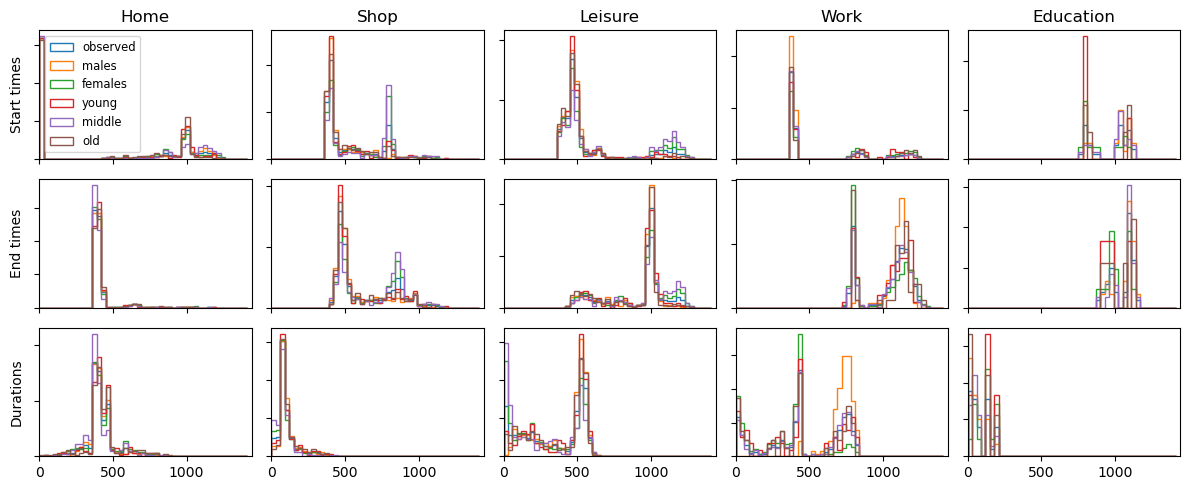

In [12]:
_ = times_distributions_plot(population, ys=subpops)

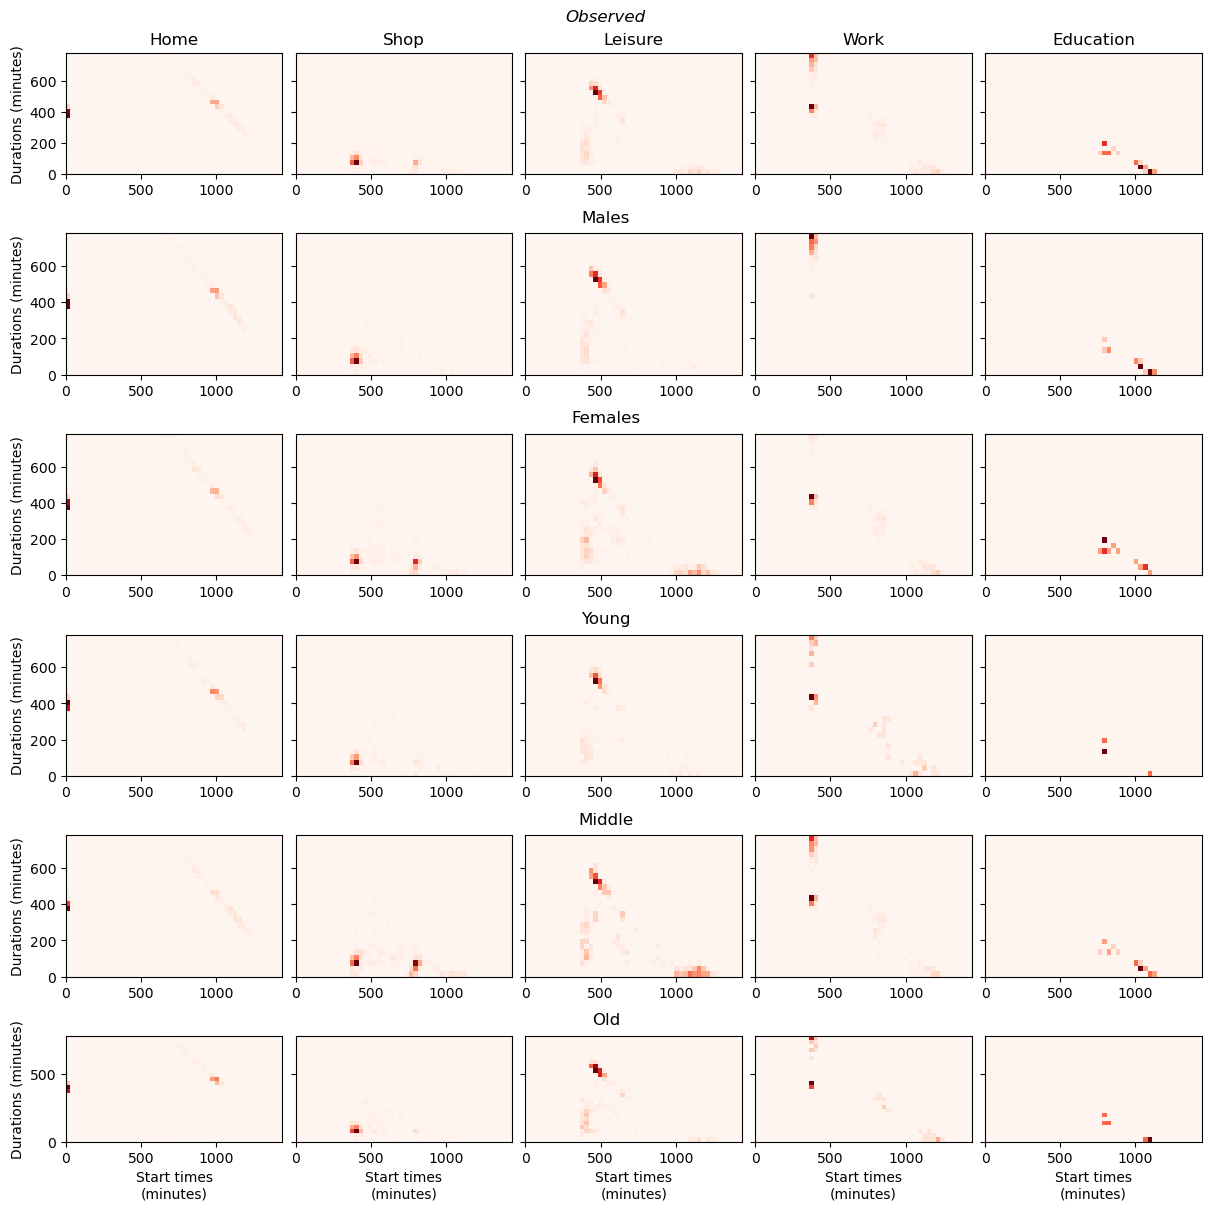

In [13]:
_ = joint_time_distributions_plot(population, ys=subpops, figsize=(12, 12))

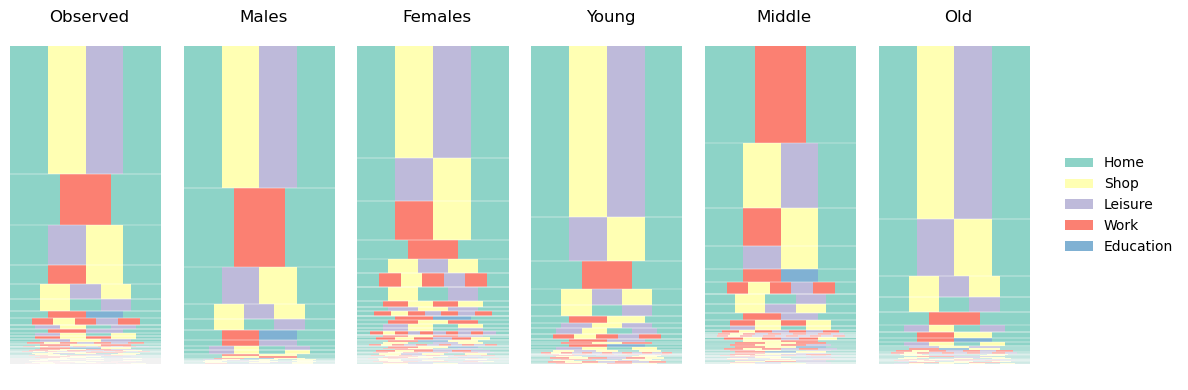

In [14]:
_ = sequence_prob_plot(population, ys=subpops, figsize=(12, 4))